# Molecular Dynamics Simulation

(c) 2008-2020 Benjamin E. Niehoff and José-Raúl González Alonso

## Introduction

In this project, we simulate a solid-fluid phase transition of Argon using a simplified Lennard-Jones model.  Each Ar atom is assumed to have no internal degrees of freedom, but is treated a pointlike particle interacting with the other particles in the simulation according to the Lennard-Jones "6-12" potential

\begin{equation}
U_{ij} = 4 \epsilon \bigg[ \bigg( \frac{\sigma}{r_{ij}} \bigg)^{12} - \bigg( \frac{\sigma}{r_{ij}} \bigg)^{6} \bigg].
\end{equation}

The simulation uses dimensionless parameters in which all fundamental physical constants have been absorbed.  Quantities are measured in terms of the following:

\begin{align}
&\text{Length} : \sigma = 3.405 \times 10^{-10} \, \mathrm{m}, & &\text{Time} : \tau = \sqrt{\frac{m_\text{Ar} \sigma^2}{\epsilon}} = 2.15 \times 10^{-12} \, \mathrm{s}, \\
&\text{Energy} : \epsilon = 1.65 \times 10^{-21} \, \mathrm{J}, & &\text{Temperature} : \frac{\epsilon}{k_\text{B}} = 120 \, \mathrm{K}, \\
&\text{Mass} : m_\text{Ar} = 6.63 \times 10^{-26} \, \mathrm{kg}, & &\text{Entropy} : k_\text{B} = 1.38 \times 10^{-23} \, \mathrm{J} / \mathrm{K},
\end{align}

and etc. for derived quantities such as velocities and forces.  The data files output by `md-simulate` are all in dimensionless units, so they can be rescaled with the above numbers, or with some other set of numbers in order to represent any material that can be well-approximated with the Lennard-Jones potential.  Note that the *time step* used in the simulation (and output in the `time_series.csv` files) is $0.005 \tau$, so that 200 time steps make up one unit of time.

## Setup

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = 'data_cellcount_14'

density_labels = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(density_labels)

temperature_labels = [t for t in os.listdir(os.path.join(dataset_path, density_labels[0]))
                      if os.path.isdir(os.path.join(dataset_path, density_labels[0], t))]
print(temperature_labels)

['rho_0.500', 'rho_0.600', 'rho_0.700', 'rho_0.800', 'rho_0.900', 'rho_1.000']
['T_0.100', 'T_0.150', 'T_0.200', 'T_0.250', 'T_0.300', 'T_0.350', 'T_0.400', 'T_0.450', 'T_0.500', 'T_0.550', 'T_0.600', 'T_0.650', 'T_0.700', 'T_0.750', 'T_0.800', 'T_0.850', 'T_0.900']


Load the data files:

In [4]:
thermo_meas_data = pd.read_csv(os.path.join(dataset_path, 'thermo_measurements.csv'))

# Drop some extraneous rows from an incomplete run
thermo_meas_data = thermo_meas_data[thermo_meas_data['Density'] <= 1.0]

final_state_data = {d : {} for d in density_labels}
summary_info_data = {d : {} for d in density_labels}
time_series_data = {d : {} for d in density_labels}

for d in density_labels:
    for t in temperature_labels:
        final_state_data[d][t] = pd.read_csv(os.path.join(dataset_path, d, t, 'final_state.csv'))
        summary_info_data[d][t] = pd.read_csv(os.path.join(dataset_path, d, t, 'summary_info.csv'))
        time_series_data[d][t] = pd.read_csv(os.path.join(dataset_path, d, t, 'time_series.csv'),
                                            index_col='TimeStep')

## Walking through a simulation

We start by giving an example of what a simulation looks like.  First some summary data:

In [26]:
summary_info_data['rho_0.800']['T_0.600']

,CellCount,SideLength,AtomCount,BlockCount,BlocksPerSide,BlockLength
0,14,23.93966,10976,0,9,2.659963


The summary info just tells us some basic information about each individual run.  This run was done with 10976 particles in a box of dimensions 23.93966 cubed.  It is divided into 9 "blocks" on each side, giving a total of 9 * 9 * 9 = 729 Blocks (the BlockCount variable is never actually used in the program, so this column is reporting incorrectly).

The algorithm runs by dividing the total volume into Blocks, and processing the pairwise Lennard-Jones forces in each Block separately (in principle this could be parallelized).  The size of a Block is chosen so that particles in a given Block can only interact with other particles in the same Block, *or* within the 8 Blocks immediately adjacent to it.  Since the Lennard-Jones potential decays quickly, we can effectively ignore the interactions with any Blocks further away.  By using this strategy of assuming that only nearby particles can actually influence a given particle's motion, we can improve our performance scaling on very large simulations.

Naively, one must calculate the force between every pair of particles.  At fixed density, the number of particles scales as the volume of the box, which means that the number of forces we must calculate scales as the total volume *squared*.  However, using the Block strategy and taking into account only the effects of adjacent blocks, then the number of forces we must calculate scales only as the total volume.

Now let's look at some data for a single run as a function of time.  At the beginning of the run, we fix the initial positions and velocities of the particles, make sure that the internal forces and torques are balanced, and then let the system evolve according to the mutual Lennard-Jones interactions.  We are attempting to achieve a specific temperature of the system *in equilibrium*, but our system does not *start* in equilibrium.  We must let the system relax for a bit, and if it is still at the wrong temperature, we need to adjust it (by scaling the velocities), and then let it relax again.  Eventually, when the temperature fluctuations stay within certain bounds, we declare the system to be at equilibrium, and we can begin doing measurements on the system.

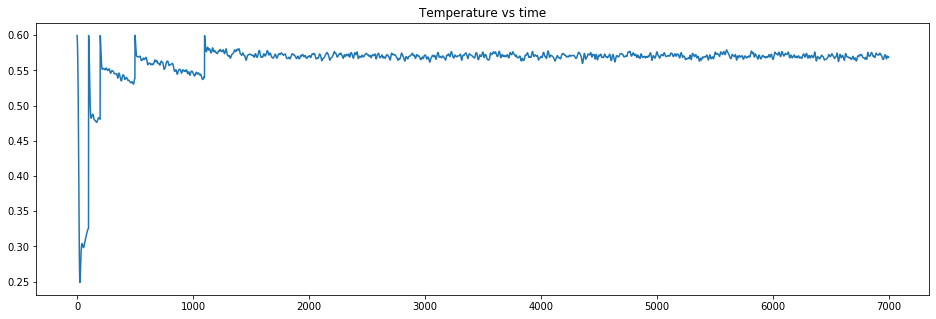

In [8]:
plt.figure(figsize=(16,5))
plt.title("Temperature vs time")

sns.lineplot(data=time_series_data['rho_0.800']['T_0.600']['Temp'])
plt.show()

In this graph of temperature vs time, you can see this process of a series of "kicks" on the system until it finally settles to a roughly-constant temperature, near the nominal temperature of $0.6 \, \epsilon / k_\text{B}$.

One useful diagnostic of our integration algorithm is to plot the total energy over time.  Since the system is closed, the total energy should be constant.  This is achieved by using a symplectic integration method (in this case, velocity-Verlet integration).

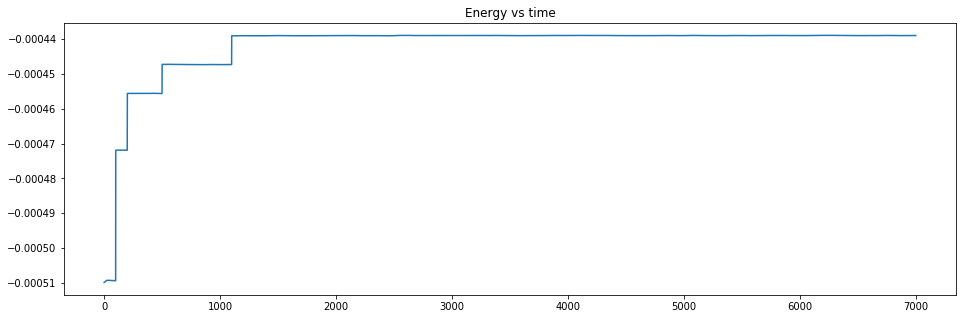

In [9]:
plt.figure(figsize=(16,5))
plt.title("Energy vs time")

sns.lineplot(data=time_series_data['rho_0.800']['T_0.600']['TotEnergy'])
plt.show()

You can see the initial adjustment "kicks" quite clearly in this graph.  After the last kick, the energy remains very nearly constant, which indicates the integration algorithm is at least producing results that make physical sense.

Of course, our velocity-Verlet integration algorithm still accumulates errors.  But it does so in a way that shouldn't affect the thermodynamics we are trying to measure.

## Distinguishing solid from fluid

The goal of the simulation is to see whether something like the Lennard-Jones potential gives us complex enough behavior to see phase transitions.  A very good indicator of the transition between solid and fluid is the *mean square displacement* of the particles, which measures, effectively, the rate of diffusion in the material.  A particle undergoing Brownian motion will tend to wander from its original starting point at a rate proportional to the *square root* of $t$, and therefore its *square* displacement will tend to grow linearly.  The slope is the rate of diffusion.

In a solid, the rate of diffusion is practically zero, so we expect the mean square displacement to stay roughly constant, once the system has settled in equilibrium.  In a fluid, by contrast, we should see linear growth.  We give two examples.

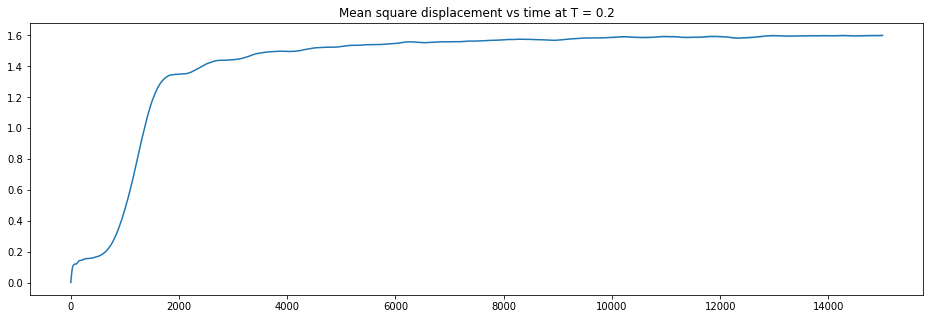

In [25]:
plt.figure(figsize=(16,5))
plt.title("Mean square displacement vs time at T = 0.2")

sns.lineplot(data=time_series_data['rho_0.800']['T_0.200']['MeanSqDisp'])
plt.show()

We see quite clearly that at low temperatures (for $T = 0.2 \, \epsilon / k_\text{B}$), the mean square displacement is constant at equilibrium, and thus we have a solid.

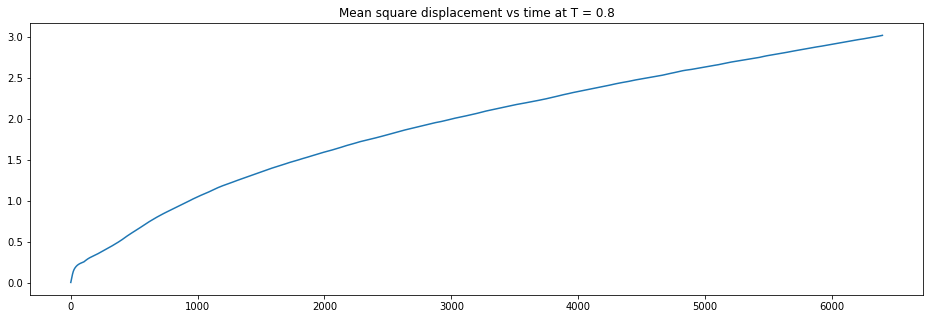

In [18]:
plt.figure(figsize=(16,5))
plt.title("Mean square displacement vs time at T = 0.8")

sns.lineplot(data=time_series_data['rho_0.800']['T_0.800']['MeanSqDisp'])
plt.show()

At high temperatures ($T = 0.8 \, \epsilon / k_\text{B}$), the mean square displacement continues to increase, showing that the particles are free to move, and therefore we have a fluid.

Looking at the mean square displacement alone, it is hard to tell whether our fluid is a liquid or a gas, as in both cases we would see linear behavior in equilibrium.  To get some idea, we can try simply looking at the final state of the system, and plot the locations of all the particles.

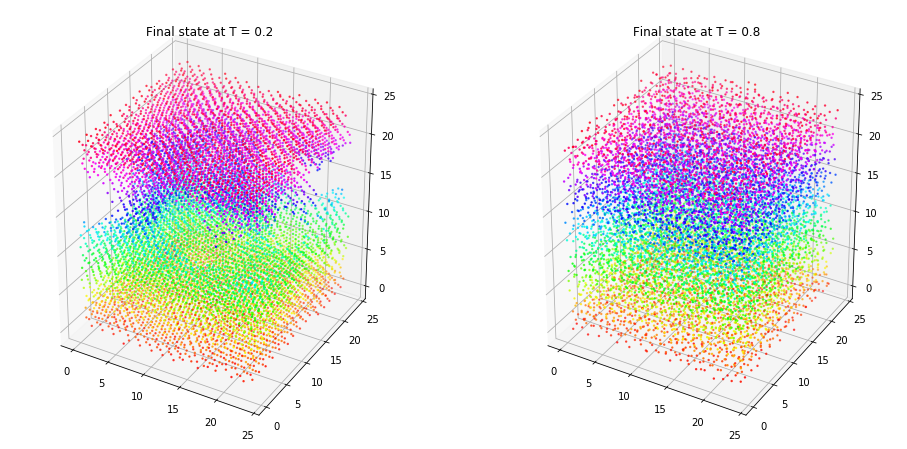

In [34]:
fig = plt.figure(figsize=(16,8))

axL = fig.add_subplot(1, 2, 1, projection='3d')
axL.set_title('Final state at T = 0.2')

final_state_slice_L = final_state_data['rho_0.800']['T_0.200']
final_state_slice_H = final_state_data['rho_0.800']['T_0.800']

axL.scatter3D(final_state_slice_L['PosX'],
            final_state_slice_L['PosY'],
            final_state_slice_L['PosZ'],
            c=final_state_slice_L['PosZ'],
            cmap='hsv',
             s=2)

axH = fig.add_subplot(1, 2, 2, projection='3d')
axH.set_title('Final state at T = 0.8')

axH.scatter3D(final_state_slice_H['PosX'],
            final_state_slice_H['PosY'],
            final_state_slice_H['PosZ'],
            c=final_state_slice_H['PosZ'],
            cmap='hsv',
             s=2)


#ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

plt.show()

As we can see, at low temperatures, the equilibrium state is a crystalline configuration of atoms (and thus obviously solid), whereas at high temperatures, the atoms are more randomly distributed.

We can also see that the low-temperature crystalline structure has "holes".  This is because the total volume and number of atoms are both fixed.  When the system solidifies, its crystal lattice has a preferred size and it no longer expands to fill the container.

In the high-temperature phase, the particles do fill the container, and we might conclude that they are a gas.  But they are also fairly dense and strongly-interacting, which is not very much like a gas.  So perhaps they are in a compressible liquid phase.

## Energy vs temperature and latent heat of fusion

It is very informative to plot the energy vs temperature curve.  A discontinuity in the E-T curve represents a first-order phase transition.  There is a jump in energy which represents the energy released by the atoms fusing into a crystal lattice (or alternatively, it is the extra heat we need to *add* to the system in order to melt it, if we are heating it up).

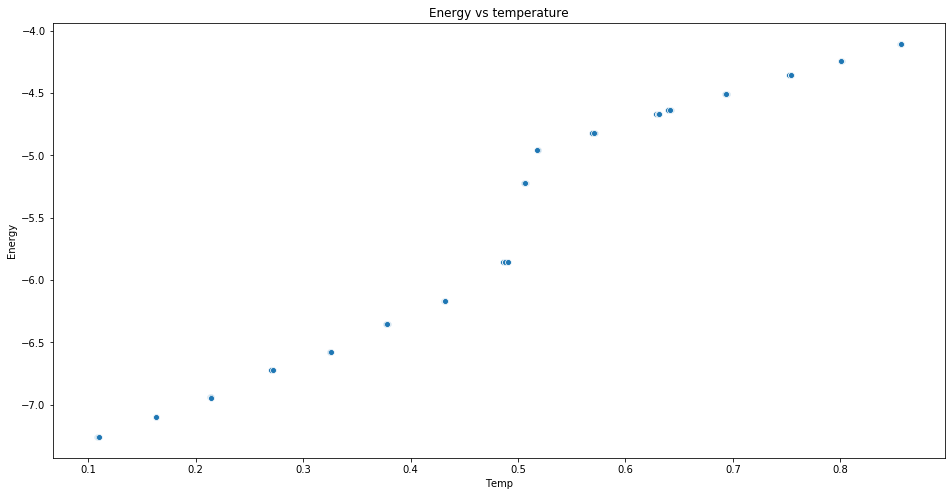

In [7]:
thermo_meas_slice = thermo_meas_data.loc[abs(thermo_meas_data['Density'] - 0.8) < 0.01]

plt.figure(figsize=(16,8))
plt.title("Energy vs temperature")

sns.scatterplot(x=thermo_meas_slice['Temp'], y=thermo_meas_slice['Energy'])
plt.show()

As we can see, this does appear to show a discontinuity around $T = 0.5 \, \epsilon / k_\text{B}$.  However, this is a very small simulation of atoms (only about 500).  A bigger simulation should be expected to give a more accurate phase transition.

We have also measured the heat capacity at constant volume, and the pressure:

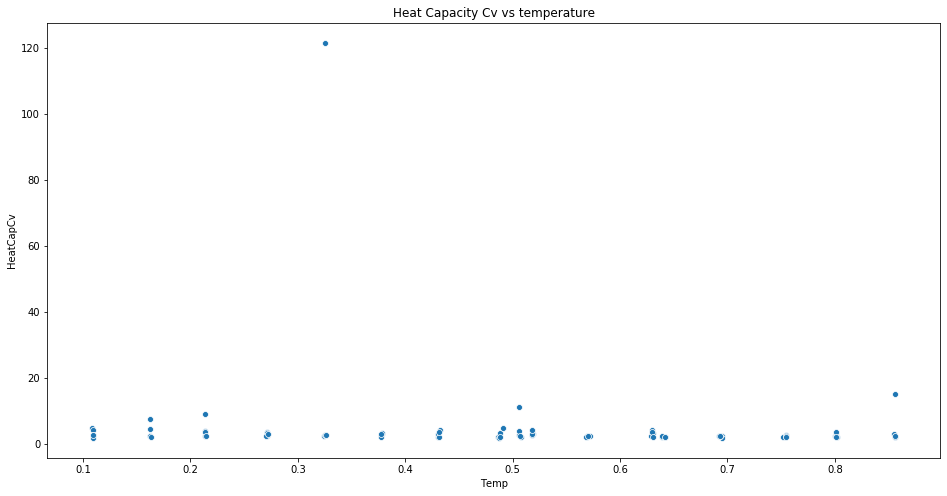

In [8]:
plt.figure(figsize=(16,8))
plt.title("Heat Capacity Cv vs temperature")

sns.scatterplot(x=thermo_meas_slice['Temp'], y=thermo_meas_slice['HeatCapCv'])
plt.show()

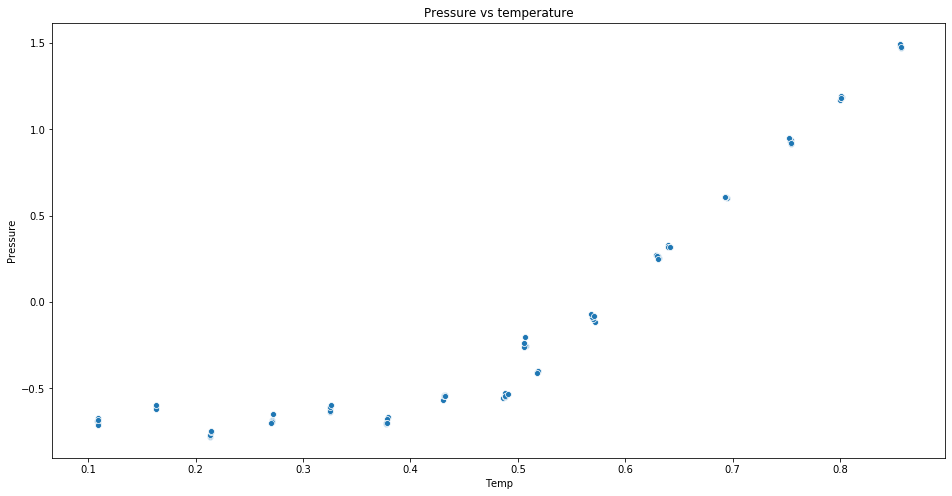

In [9]:
plt.figure(figsize=(16,8))
plt.title("Pressure vs temperature")

sns.scatterplot(x=thermo_meas_slice['Temp'], y=thermo_meas_slice['Pressure'])
plt.show()

The pressure again clearly shows the change in phase around temperature 0.5.  At low temperatures, the pressure is constant (and slightly negative, because of the attractive Lennard-Jones force), while at high temperatures, the pressure increases linearly with temperature, like an ideal gas.

## Energy vs temperature and density

By plotting energy over two axes of temperature and density, we can begin to visualize what the phase diagram of this system looks like.

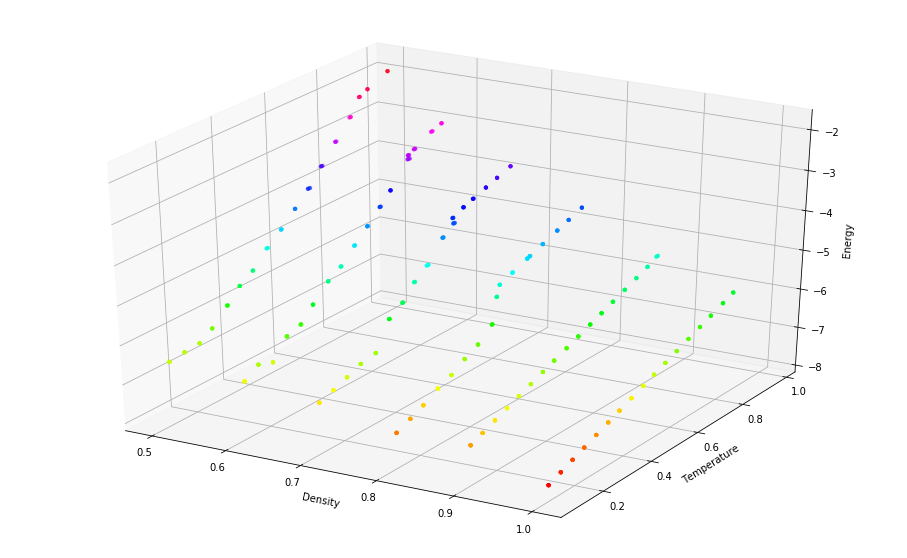

In [5]:
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax.set_title('Energy vs density and temperature')

ax.scatter3D(thermo_meas_data['Density'],
            thermo_meas_data['Temp'],
            thermo_meas_data['Energy'],
            c=thermo_meas_data['Energy'],
            cmap='hsv',
            s=10)

ax.set_xlabel('Density')
ax.set_ylabel('Temperature')
ax.set_zlabel('Energy')

plt.show()

In our runs with ~10000 particles, we are getting very consistent data to fill out the $E(\rho,T)$ surface.  It looks like everything interesting happens for densities between 0.7 and 0.9.